In [588]:
# Loading the libararies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from dowhy import gcm

from itertools import combinations
from scipy.stats import pearsonr
import statsmodels.api as sm

In [589]:
def conditional_independence_test(data, X, Y, S, alpha=0.05):
    """
    input
        data = The data frame containing the variables.
        X, Y = two variables to test for independence.
        S = Names of the conditioning set variables.
        alpha = Significance level for the test.
        
    output:
        bool: True if X is conditionally independent of Y given S, False otherwise.
    """
    # Pearson measure is used to calculat the simliraty between two datasets
    
    if len(S) == 0:  # If we have no observation:
        corr, _ = pearsonr(data[X], data[Y])
    else:            # If we have some observations
        variables = [X, Y] + S
        df = data[variables].dropna() # removing degenrate data
        X_res = sm.OLS(df[X], df[S]).fit().resid
        Y_res = sm.OLS(df[Y], df[S]).fit().resid
        corr, _ = pearsonr(X_res, Y_res)
    
    return corr < alpha

In [590]:
# Build the skeleton of the causal graph using conditional independence tests
# Does not define the directions on the edges

def build_skeleton(data, alpha=0.05):
    """
    input:
        data = The data frame containing the variables.
        alpha = Significance level for the tests.
        
    output:
        adjacency_matrix (pd.DataFrame): The adjacency matrix of the skeleton graph.
    """
    variables = data.columns
    graph = nx.complete_graph(variables) # Initializing the full graph
    sep_set = {frozenset({X, Y}): set() for X in variables for Y in variables if X != Y} # empty d-seperation set for each pair of nodes
    
    for l in range(len(variables)): # iteration of each random variable
        for X, Y in combinations(variables, 2): # iteration over all possible pairs of random variablees
            if graph.has_edge(X, Y):
                for S in combinations([v for v in variables if v not in {X, Y}], l): # all possible observations
                    # removing the edge if the conditional independency is satisfies
                    if conditional_independence_test(data, X, Y, list(S), alpha):
                        graph.remove_edge(X, Y)
                        sep_set[frozenset({X, Y})] = set(S) # removing it from the sepereation set
                        break
    
    return graph, sep_set


In [591]:
def orient_edges(graph, sep_set):
    """   
    input:
        adjacency_matrix = The adjacency matrix of the skeleton graph.
        sep_set = The separation sets from the skeleton building phase.
        
    output:
        directed_graph (pd.DataFrame) = The adjacency matrix of the directed graph.
    """
    directed_graph = nx.DiGraph() # Directed graph object created
    directed_graph.add_nodes_from(graph.nodes) # Adding the nodes
    for X, Y in graph.edges: # Drawing edges in both directions between all nodes - to be later removed
        directed_graph.add_edge(X, Y)
        directed_graph.add_edge(Y, X)
    
    # we start to remove the unwanted direction
    for X, Y in combinations(graph.nodes, 2): # Iteration over all pairs
        if directed_graph.has_edge(X, Y) and directed_graph.has_edge(Y, X): # If there are edges at both directions
            for Z in graph.nodes:
                if Z not in {X, Y} and directed_graph.has_edge(X, Z) and directed_graph.has_edge(Z, Y):
                    if frozenset({X, Y}) not in sep_set or Z not in sep_set[frozenset({X, Y})]:
                        directed_graph.remove_edge(Y, X)
    
    return directed_graph

In [592]:
# PC Algorithm 

def pc_algorithm(data, alpha=0.05):
    """   
    input:
        data = The data frame containing the variables.
        alpha = Significance level for the tests.
        
    output:
        directed_graph = The adjacency matrix of the directed graph.
    """
    # Building the direction-less skeltion of the graph
    skeleton, sep_set = build_skeleton(data, alpha)
    
    # Finding the directions
    directed_graph = orient_edges(skeleton, sep_set)
    return directed_graph


In [593]:
#  usage:
data = pd.read_csv("./AirQuality_Edit.csv")
G = pc_algorithm(data , 0.01)



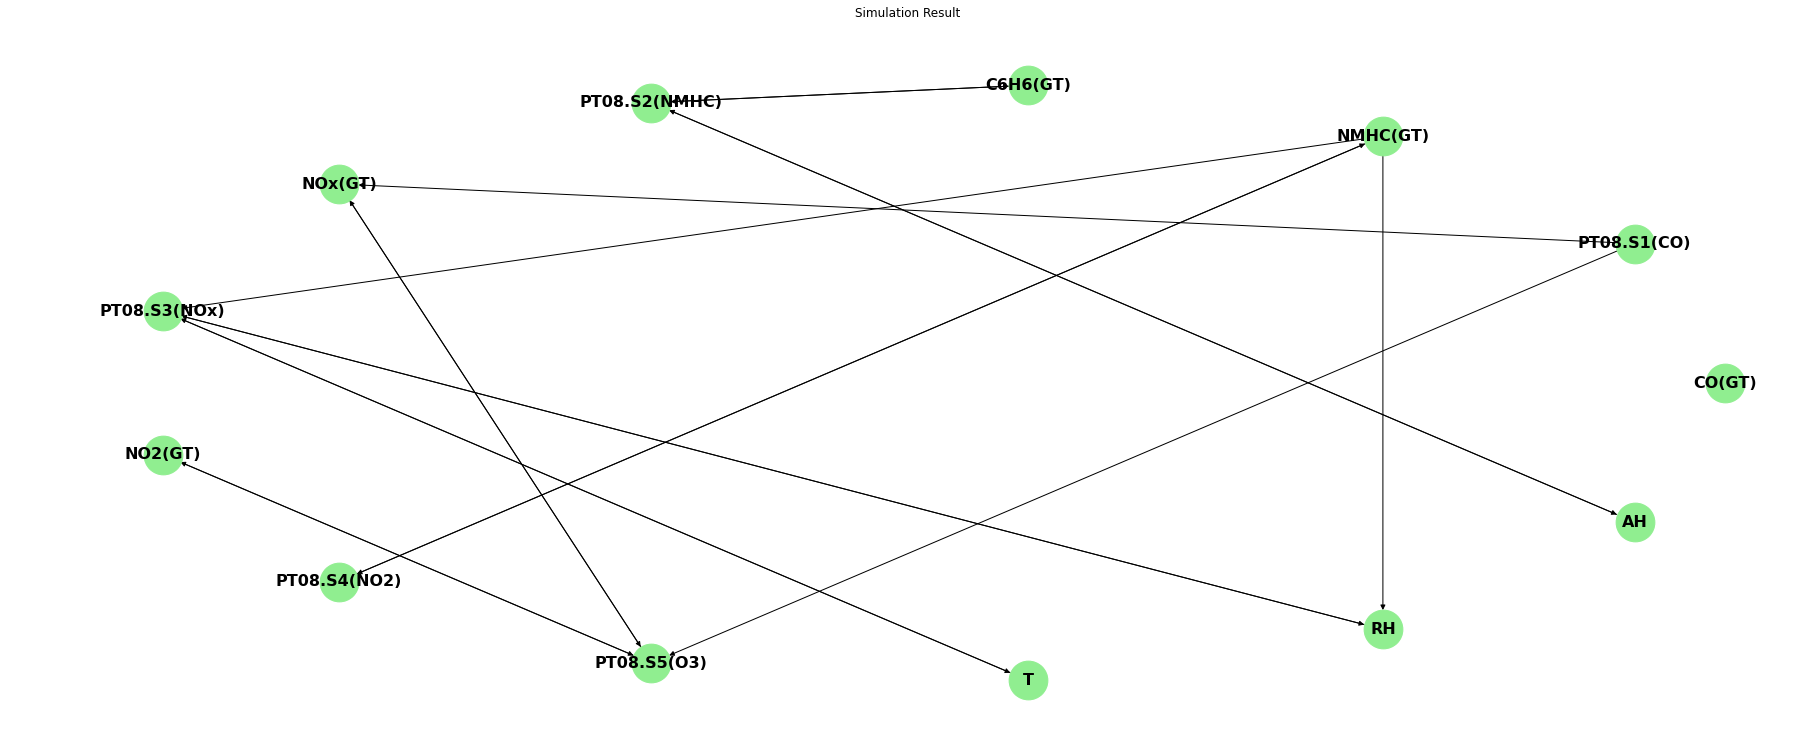

In [594]:
# Plotting the result

plt.figure(figsize=(25, 10))  # Set figure size


# Circular Layout

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, font_size=16, font_color='black', font_weight='bold')
plt.title('Simulation Result')
plt.savefig("result.png")
plt.show()
